# Summarize the data

#### How many hospitals filed more than one report in the same year? Show your answer as a line graph of the number of hospitals over time.

In [1]:
import pandas as pd

# read data\output\HCRIS_Data.csv
data = pd.read_csv('data\output\HCRIS_Data.csv')

c:\Users\huang\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
data.head(5)

,provider_number,fy_start,fy_end,date_processed,date_created,beds,tot_charges,tot_discounts,tot_operating_exp,ip_charges,...,secondary_mcare_payment,street,city,state,zip,county,hvbp_payment,hrrp_payment,year,source
0,10001,2007-10-01,2008-09-30,2013-05-03,2013-04-24,370.0,8.843897e+08,663141859.0,235522719.0,87613622.0,...,681771.0,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301-,HOUSTON,NaN,NaN,2008,primary report
1,10001,2007-10-01,2008-09-30,2013-05-03,2013-04-24,370.0,8.843897e+08,663141859.0,235522719.0,87613622.0,...,681771.0,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301-,HOUSTON,NaN,NaN,2008,primary report
2,10001,2008-10-01,2009-09-30,2010-11-03,2010-10-25,370.0,9.807761e+08,744725360.0,244567428.0,91187217.0,...,557218.0,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301-,HOUSTON,NaN,NaN,2009,primary report
3,10001,2008-10-01,2009-09-30,2010-11-03,2010-10-25,370.0,9.807761e+08,744725360.0,244567428.0,91187217.0,...,557218.0,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301-,HOUSTON,NaN,NaN,2009,primary report
4,10001,2009-10-01,2010-09-30,2011-08-09,2011-08-05,408.0,1.116894e+09,866681575.0,258285960.0,108561942.0,...,108849.0,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301-,HOUSTON,NaN,NaN,2010,primary report


In [3]:
n_reports=data.groupby(['year','provider_number']).agg({'provider_number':'count'}).rename(columns={'provider_number':'count'}).reset_index()
# filter out providers with more than 1 report per year
n_reports=n_reports[n_reports['count']>1]
n_reports=n_reports.groupby('year').agg({'count':'count'})
# add rows for years with no providers with more than 1 report with 0 count
for year in range(2007,2016):
    if year not in n_reports.index:
        n_reports.loc[year]=0

n_reports=n_reports.sort_index()
n_reports

,count
year,
2007,0
2008,3258
2009,5863
2010,5879
2011,263
2012,0
2013,0
2014,0
2015,0


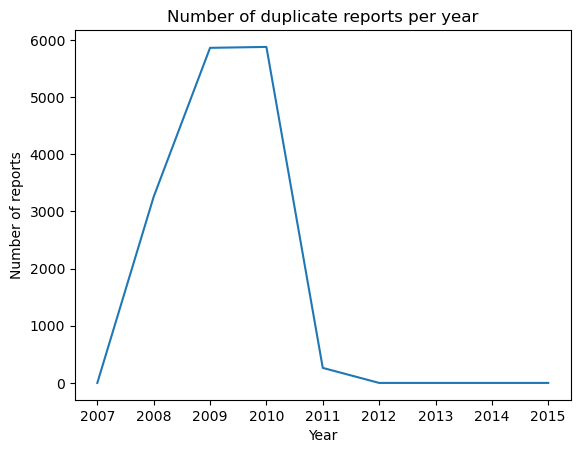

In [4]:
# plot the number of reports per year using matplotlib
import matplotlib.pyplot as plt
plt.plot(n_reports.index,n_reports['count'])
# adjust the x-axis to show all years
plt.xticks(n_reports.index)
plt.title('Number of duplicate reports per year')
plt.xlabel('Year')
plt.ylabel('Number of reports')
q1_fig = plt.gcf()
plt.show()



### After removing/combining multiple reports, how many unique hospital IDs (Medicare provider numbers) exist in the data?

In [5]:
# remove multiple reports, keeping only the first one
data1=data.drop_duplicates(subset=['year','provider_number'],keep='first')

In [6]:
# number of unique providers
q2_allyear=data1['provider_number'].nunique()
q2_allyear

6747

In [7]:
# number of unique providers over years
n_providers=data1.groupby('year').agg({'provider_number':'nunique'})
q2_peryear=n_providers
q2_peryear

,provider_number
year,
2007,16
2008,3525
2009,6100
2010,6103
2011,6097
2012,6140
2013,6066
2014,6064
2015,6042


### What is the distribution of total charges (tot_charges in the data) in each year? Show your results with a “violin” plot, with charges on the y-axis and years on the x-axis.

In [8]:
# filter out na for tot_charges
data1=data1.dropna(subset=['tot_charges'])
data1=data1[data1['tot_charges']<1000000000]

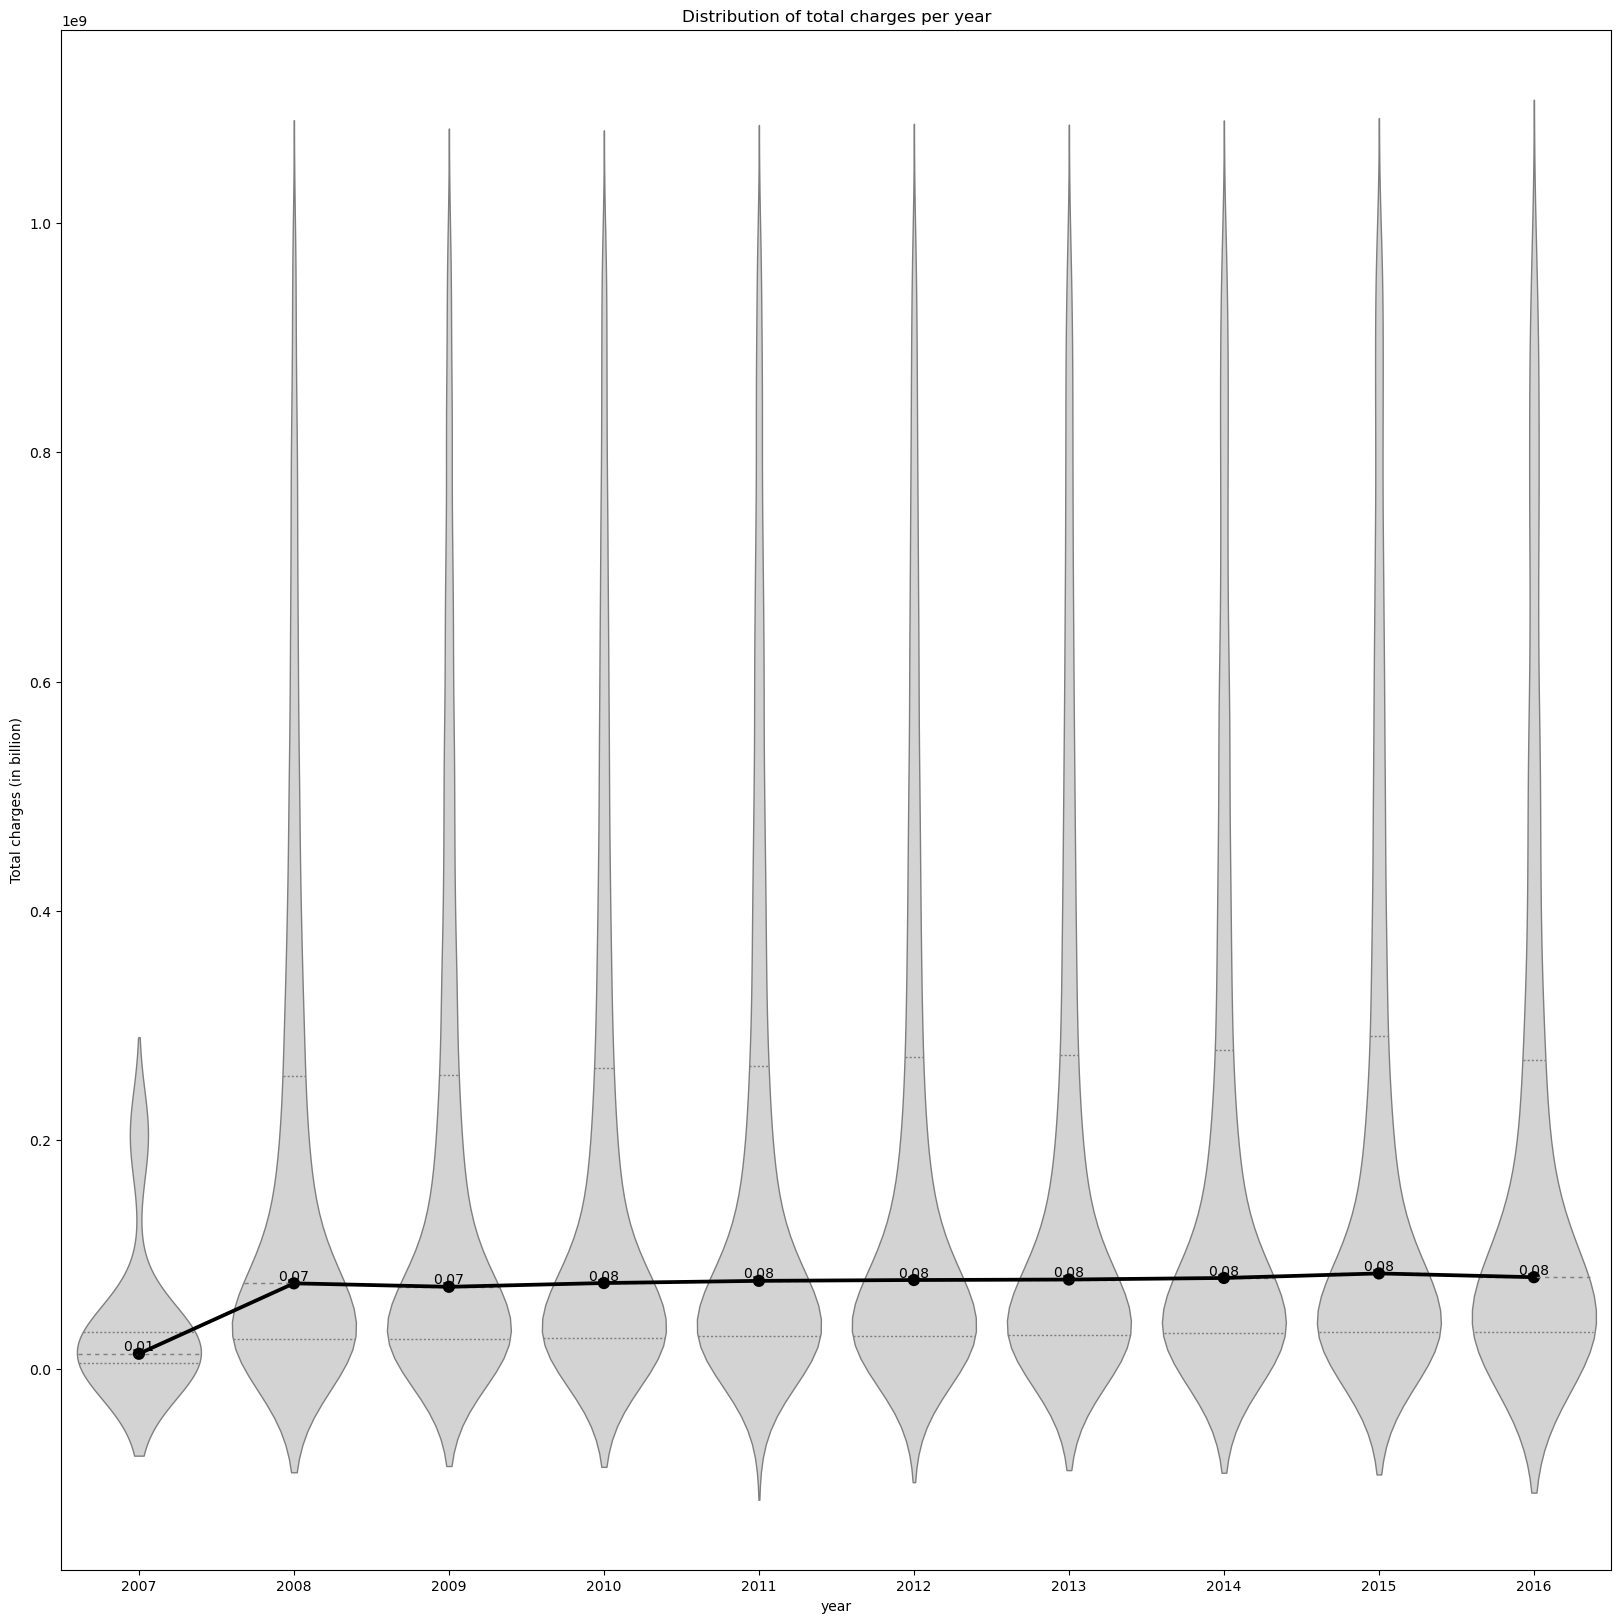

In [9]:
# What is the distribution of total charges (tot_charges in the data) in each year? Show your results with a “violin” plot, with charges on the y-axis and years on the x-axis.
# use ggplot style and ignore outliers. also show the points in the plot.
import seaborn as sns

plt.figure(figsize=(20,20))
sns.violinplot(x='year',y='tot_charges',data=data1, inner="quartiles", color='lightgray', linewidth=1, showfliers=False, scale='width')

# connect the median values
sns.pointplot(x='year',y='tot_charges',data=data1.groupby('year').agg({'tot_charges':'median'}).reset_index(),color='black')
# change 1e9 to 1 billion
plt.ylabel('Total charges (in billion)')
# write the median values on the plot, make sure they are readable and not overlapped with the line
for i in range(0,10):
    plt.text(i, data1.groupby('year').agg({'tot_charges':'median'}).reset_index().iloc[i,1], round(data1.groupby('year').agg({'tot_charges':'median'}).reset_index().iloc[i,1]/1e9,2), ha='center', va='bottom')
    
plt.title('Distribution of total charges per year')
q3_fig = plt.gcf()
plt.show()




### What is the distribution of estimated prices in each year? Again present your results with a violin plot, and recall our formula for estimating prices from class. 

In [10]:
# define the variable 'tot_discounts' here with the appropriate value
# mute the warning
data2=data.copy()
pd.options.mode.chained_assignment = None
data2['discount_factor'] = 1 - data2['tot_discounts'] / data2['tot_charges']
data2['price_num'] = (data2['ip_charges'] + data2['icu_charges'] + data2['ancillary_charges']) * data2['discount_factor'] - data2['tot_mcare_payment']
data2['price_denom'] = data2['tot_discharges'] - data2['mcare_discharges']
data2['price'] = data2['price_num'] / data2['price_denom']

# filter out na for price and negative values
data2=data2.dropna(subset=['price_num','price_denom'])
data2=data2[(data2['price']>0)&(data2['price']<100000)&(data2['price_num']>0)&(data2['price_denom']>100)]


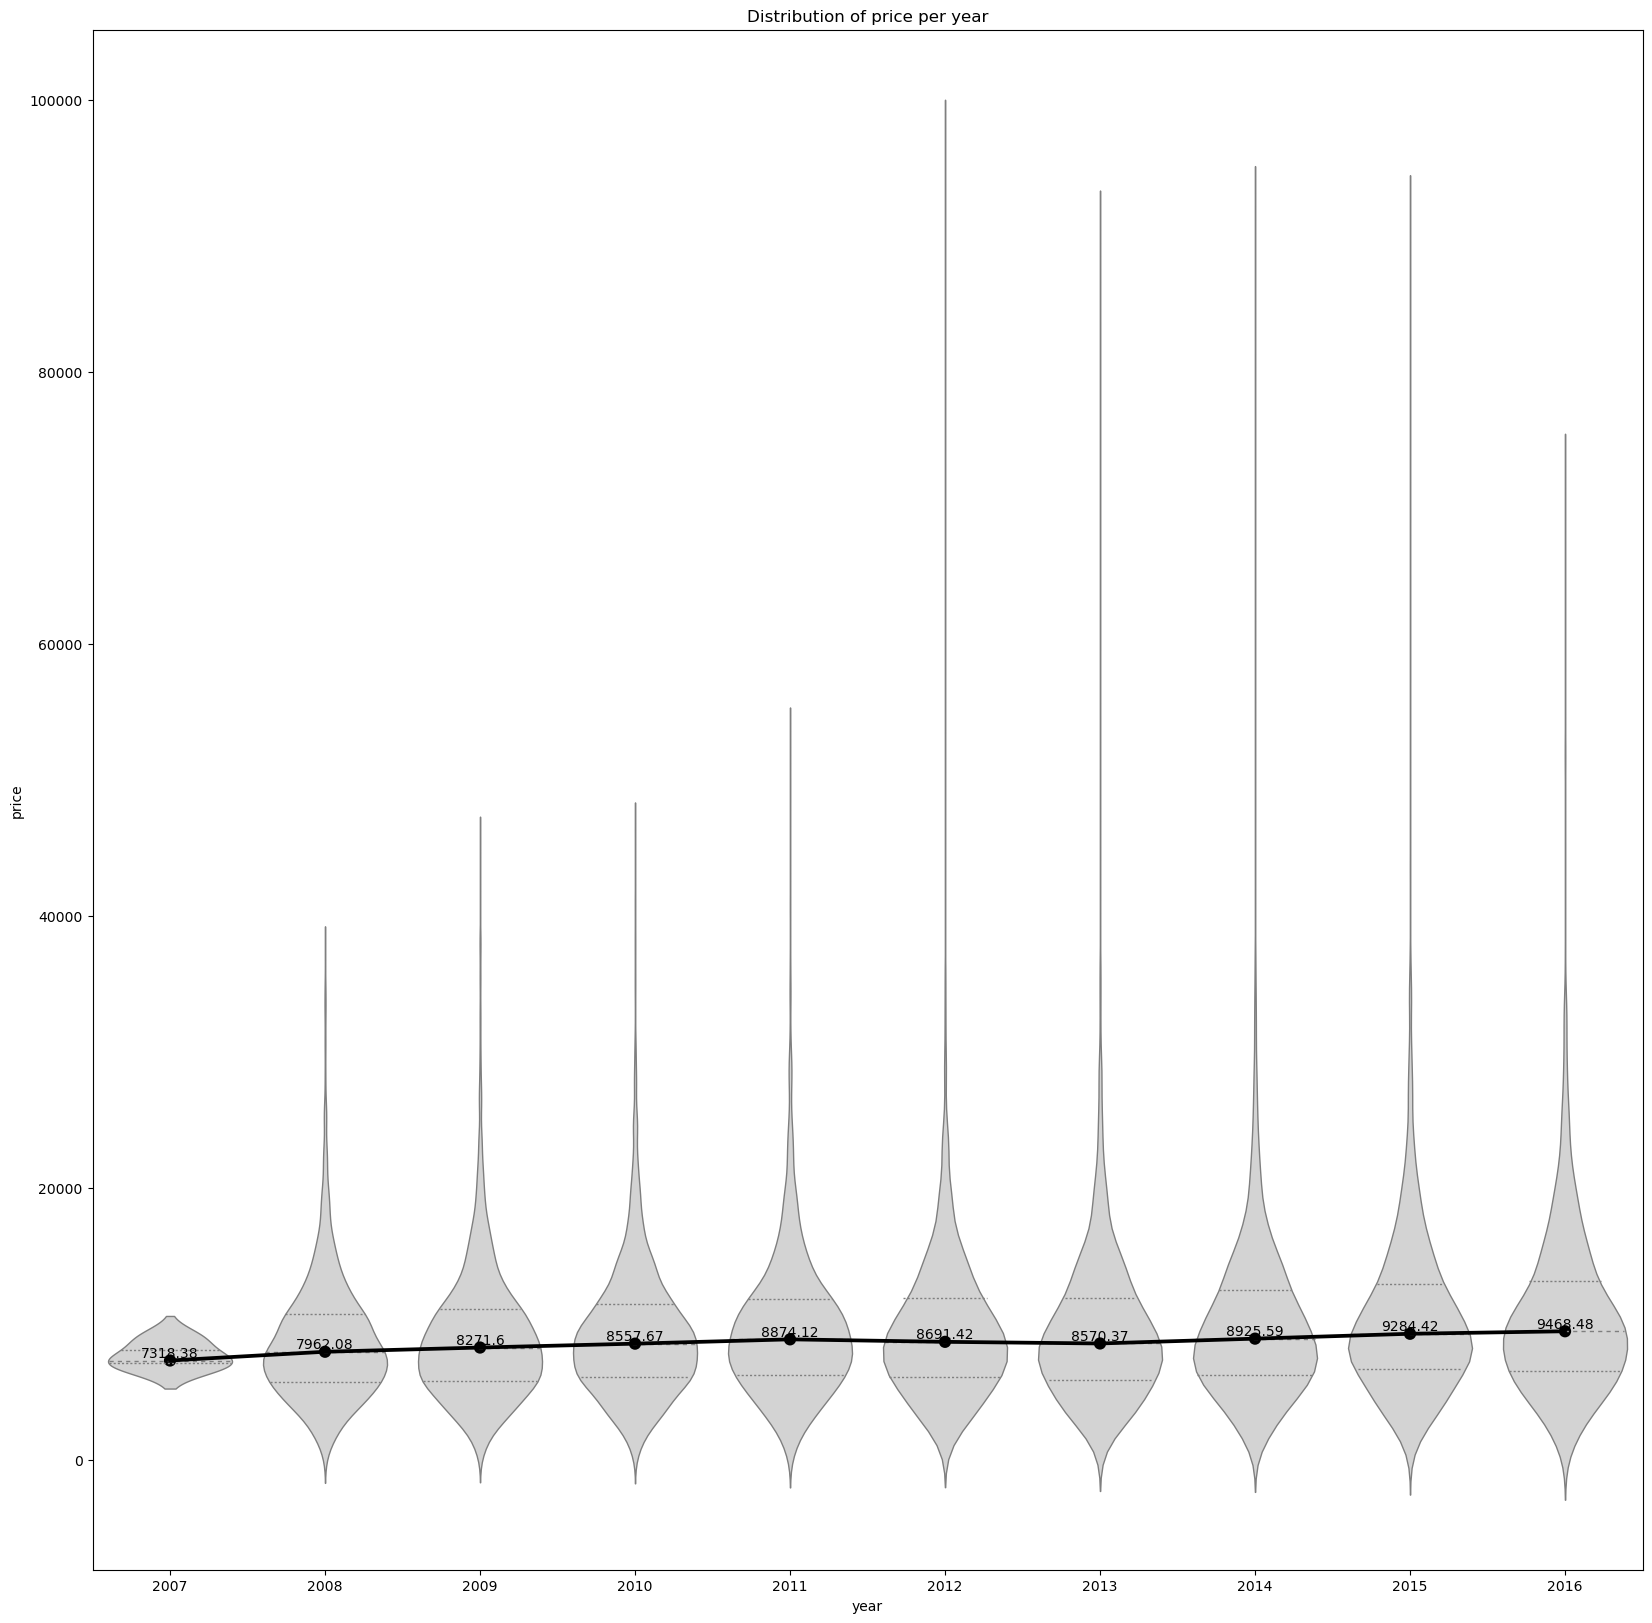

In [11]:
# plot violin plot for price
plt.figure(figsize=(20,20))
sns.violinplot(x='year',y='price',data=data2, inner="quartiles", color='lightgray', linewidth=1, showfliers=False, scale='width')
# connect the median values
sns.pointplot(x='year',y='price',data=data2.groupby('year').agg({'price':'median'}).reset_index(),color='black')
# write the median values on the plot, make sure they are readable and not overlapped with the line
for i in range(0,10):
    plt.text(i, data2.groupby('year').agg({'price':'median'}).reset_index().iloc[i,1], round(data2.groupby('year').agg({'price':'median'}).reset_index().iloc[i,1],2), ha='center', va='bottom')

plt.title('Distribution of price per year')
q4_fig = plt.gcf()
plt.show()


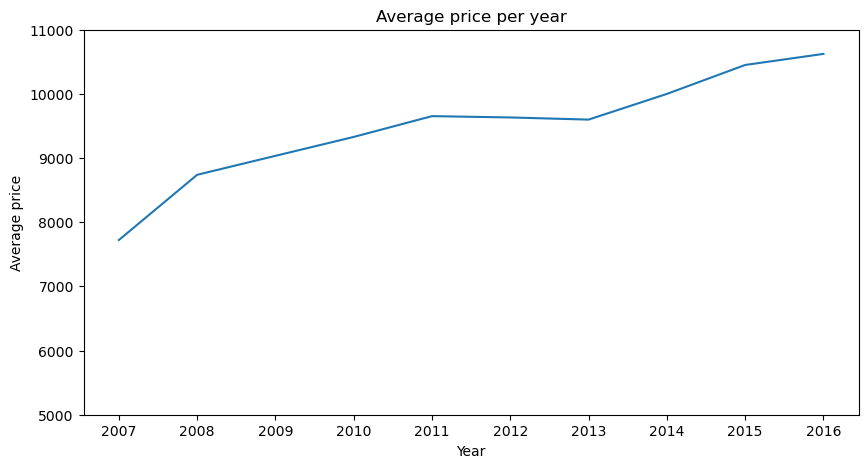

In [12]:
# plot average price per year
plt.figure(figsize=(10,5))
price_avg=data2.groupby('year').agg({'price':'mean'})
plt.plot(price_avg.index,price_avg['price'])
plt.xticks(price_avg.index)
plt.title('Average price per year')
plt.xlabel('Year')
plt.ylim(5000,11000)
plt.ylabel('Average price')
plt.show()


# Estimate ATEs

### Calculate the average price among penalized versus non-penalized hospitals.

In [13]:
pd.options.mode.chained_assignment = None
data12=data[data['year']==2012].drop_duplicates(subset=['year','provider_number'],keep='first')

data12['discount_factor'] = 1 - data12['tot_discounts'] / data12['tot_charges']
data12['price_num'] = (data12['ip_charges'] + data12['icu_charges'] + data12['ancillary_charges']) * data12['discount_factor'] - data12['tot_mcare_payment']
data12['price_denom'] = data12['tot_discharges'] - data12['mcare_discharges']
data12['price'] = data12['price_num'] / data12['price_denom']

# filter out na for price and negative values
data12=data12.dropna(subset=['price_num','price_denom'])
data12=data12[(data12['price']>0)&(data12['price']<100000)&(data12['price_num']>0)&(data12['price_denom']>100)&(data12['beds']>30)]


In [14]:
# replace na in hvbp_payment and hrrp_payment with 0
data12['hvbp_payment']=data12['hvbp_payment'].fillna(0)
data12['hrrp_payment']=data12['hrrp_payment'].fillna(0)

# for HRRP payement, make all absolute values
data12['hrrp_payment']=abs(data12['hrrp_payment'])

# create a new column 'panelty' by hvbp_payment - hrrp_payment and if this is negative, the value is 1
data12['penalty']=data12['hvbp_payment']-data12['hrrp_payment']
data12['penalty']=data12['penalty'].apply(lambda x: 1 if x<0 else 0)

data12['beds_1'] = data12['beds'].apply(lambda x: 1 if x <= 92 else 0)
data12['beds_2'] = data12['beds'].apply(lambda x: 1 if x > 92 and x <= 160 else 0)
data12['beds_3'] = data12['beds'].apply(lambda x: 1 if x > 160 and x <= 282 else 0)
data12['beds_4'] = data12['beds'].apply(lambda x: 1 if x > 282 else 0)

data12.to_csv('data\output\HCRIS_Data_2012.csv',index=False)


In [15]:
# Calculate the average price among penalized versus non-penalized hospitals
penalized=data12[data12['penalty']==1]['price'].mean()
non_penalized=data12[data12['penalty']==0]['price'].mean()
penalized,non_penalized, penalized-non_penalized

# create a table for the average price among penalized versus non-penalized hospitals and the difference
q5_table=pd.DataFrame({'penalized':[penalized],'non_penalized':[non_penalized],'difference':[penalized-non_penalized]})
# change row names
q5_table.index=['Average price']
q5_table

,penalized,non_penalized,difference
Average price,9896.308498,9560.413227,335.895271


### Split hospitals into quartiles based on bed size. To do this, create 4 new indicator variables, where each variable is set to 1 if the hospital’s bed size falls into the relevant quartile. Provide a table of the average price among treated/control groups for each quartile.

In [16]:
data12['beds'].describe()

count    2733.000000
mean      217.369191
std       189.088056
min        31.000000
25%        92.000000
50%       160.000000
75%       282.000000
max      2169.000000
Name: beds, dtype: float64

In [17]:
penalized_data = data12[data12['penalty'] == 1]
penalized_data['beds_1'] = penalized_data['beds'].apply(lambda x: 1 if x <= 92 else 0)
penalized_data['beds_2'] = penalized_data['beds'].apply(lambda x: 1 if x > 92 and x <= 160 else 0)
penalized_data['beds_3'] = penalized_data['beds'].apply(lambda x: 1 if x > 160 and x <= 282 else 0)
penalized_data['beds_4'] = penalized_data['beds'].apply(lambda x: 1 if x > 282 else 0)

# create another column 'beds_quartile' with the 25th, 50th, and 75th percentiles
penalized_data['beds_quartile'] = penalized_data['beds'].apply(lambda x: '1st' if x <= 92 else ('2nd' if x > 92 and x <= 160 else ('3rd' if x > 160 and x <= 282 else '4th')))
# calculate the average price for each quartile and summarize the results in a table
penalized_data.groupby('beds_quartile').agg({'price':'mean'}).reset_index().rename(columns={'price':'average_price'})




,beds_quartile,average_price
0,1st,8286.337994
1,2nd,8721.033188
2,3rd,10132.314630
3,4th,12068.478828


In [18]:
# repeat the same for non-penalized hospitals
non_penalized_data = data12[data12['penalty'] == 0]
non_penalized_data['beds_1'] = non_penalized_data['beds'].apply(lambda x: 1 if x <= 92 else 0)
non_penalized_data['beds_2'] = non_penalized_data['beds'].apply(lambda x: 1 if x > 92 and x <= 160 else 0)
non_penalized_data['beds_3'] = non_penalized_data['beds'].apply(lambda x: 1 if x > 160 and x <= 282 else 0)
non_penalized_data['beds_4'] = non_penalized_data['beds'].apply(lambda x: 1 if x > 282 else 0)

# create another column 'beds_quartile' with the 25th, 50th, and 75th percentiles
non_penalized_data['beds_quartile'] = non_penalized_data['beds'].apply(lambda x: '1st' if x <= 92 else ('2nd' if x > 92 and x <= 160 else ('3rd' if x > 160 and x <= 282 else '4th')))
# calculate the average price for each quartile and summarize the results in a table
non_penalized_data.groupby('beds_quartile').agg({'price':'mean'}).reset_index().rename(columns={'price':'average_price'})


,beds_quartile,average_price
0,1st,7696.470378
1,2nd,8525.607482
2,3rd,9848.403610
3,4th,12367.332086


In [19]:
# merge the two tables by 'beds_quartile', rename the columns
merged=pd.merge(penalized_data.groupby('beds_quartile').agg({'price':'mean'}).reset_index().rename(columns={'price':'penalized_average_price'}),non_penalized_data.groupby('beds_quartile').agg({'price':'mean'}).reset_index().rename(columns={'price':'non_penalized_average_price'}),on='beds_quartile')
q6_table=merged
q6_table

,beds_quartile,penalized_average_price,non_penalized_average_price
0,1st,8286.337994,7696.470378
1,2nd,8721.033188,8525.607482
2,3rd,10132.314630,9848.403610
3,4th,12068.478828,12367.332086


### Find the average treatment effect using each of the following estimators, and present your results in a single table

In [23]:
# load .Rdata file
import pyreadr
result = pyreadr.read_r('matching_est.rdata')
result.keys()

sum_table=result['sum_table']
reg2_sum=result['reg2_sum']


In [21]:
import pickle

with open('hwk2_Q1-6.pkl', 'wb') as f:
    pickle.dump((q1_fig, q2_allyear, q2_peryear, q3_fig, q4_fig, q5_table, q6_table, sum_table, reg2_sum), f)